Før du starter, installer modulen ved å kjøre følgende linje

In [1]:
%pip install -q xdai

<img src="gpr_vis_9.png" width = 100%>

# Med kunstig intelligens som labpartner
## Komprimert fremgangsmåte

<a href="https://hazelbright.github.io/xdai">XDAI</a> og dette dokumentet er utviklet av Audun Skau Hansen <a href="mailto:auduns@uio.no">✉</a>, Stian Kogler, Hanne Røberg-Larsen, Steven H. R. Wilson, Elias Dalan, Ayla S. Coder, Hanan Gharayba og Maren H.S. Johnsen ved Universitetet i Oslo, våren 2023.

---


In [32]:
import xdai 
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Optimerte parametere: [0.00150721 0.17006245 0.00053109]


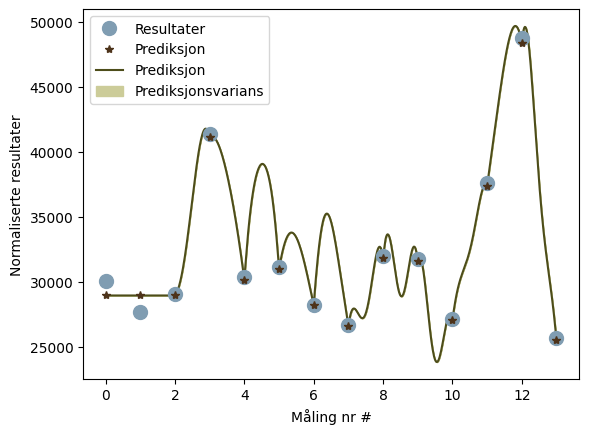

In [76]:
# eksperimentell design
limits = [[ , ], [ , ], [ , ] ] #sett inn dine grenser her
målinger = xdai.designer.doe_grid(limits, design = 2)

# datainnsamling
resultater = np.array([])



# bearbeiding av data : 
# du kan eventuelt fjerne målinger fra settet
indx = np.ones(len(resultater), dtype = bool)
#indx[14:] = False # kommenter inn for å fjerne måling nummer 15
resultater = resultater[indx]
målinger = målinger[indx]

# trening av modellen 

# juster på disse to for å få gode resultater i plottet under
parametre = np.ones(målinger.shape[1])*.0001
måling_standardavvik = .01
optimale_parametre = xdai.gpr.parameter_optimization(målinger,-resultater, params = np.log10(parametre), training_subset = np.arange(3,resultater.shape[0]),measurement_standard_deviation=måling_standardavvik) #, normalize_y = True)
print("Optimerte parametere:", optimale_parametre)

# endelig regressor
gpr = xdai.gpr.Regressor(målinger, -resultater,measurement_standard_deviation=måling_standardavvik, params = optimale_parametre) 


# vi plotter resultatene
plt.figure()

# resultatene
plt.plot(resultater, "o", label = "Resultater", zorder = 4, markersize = 10, color = np.array([.1,.2,.3])**.3)

# prediksjonene
plt.plot(-1*gpr.predict(målinger), "*", label = "Prediksjon", zorder = 5, color = np.array([.3,.2,.1]))

X3p = interp1d(np.linspace(0,1,målinger.shape[0]), målinger.T)(np.linspace(0,1,målinger.shape[0]*50))

fx, fv = gpr.predict(X3p.T, return_variance = True) #predict results and variance


plt.plot(np.linspace(0,målinger.shape[0]-1,målinger.shape[0]*50),-1*fx,"-",  label = "Prediksjon", color = (.3,.3,.1))
plt.fill_between(np.linspace(0,målinger.shape[0]-1,målinger.shape[0]*50),-fx-fv,-fx+fv,  label = "Prediksjonsvarians", color = (.8,.8,.6))
plt.ylabel("Normaliserte resultater")
plt.xlabel("Måling nr #")
plt.legend()
plt.show()


In [77]:
# I denne cellen søker vi etter ett enkelt optimum

# øvre og nedre terskelverdier for målevariablene (optimeringen vil ikke søke utenfor dette området)
bounds = np.array([[1,3,10],[120,300,480]])

# velg et sted å starte søket fra
guess = målinger[np.argmax(resultater)]

# prediker et optimum
opt, optfun, suc = gpr.predict_sample_optimum( guess,  xi = .03, bounds = bounds )

# xi = "utforskningsparameter" - hvor mye algoritmen søker seg ut fra kjente områder
# opt = målepunktet for det predikerte optimum
# optfun = funksjonsverdien i dette punktet
# suc = 0 hvis optimeringen ikke konvergerte, 1 ellers
print("Søket startet i ", guess)
print("Søket konvergerte", "ikke"*np.abs(1-suc))
print("Endelig optimum", opt)
print("(negativ) Optimal verdi er %f med varians %f." % gpr.predict(opt.reshape(-1,3), return_variance = True))
print("Tidligere kjent optimalverdi er ", -resultater[np.argmax(resultater)])

opt = opt.reshape(-1,3)


Søket startet i  [20.  9. 90.]
Søket konvergerte 
Endelig optimum [19.01469418  8.69123042 98.5185361 ]
(negativ) Optimal verdi er -50325.661637 med varians 0.091200.
Tidligere kjent optimalverdi er  -48801.94


In [ ]:
# (alternativt) i denne cellen søker vi etter flere optima

opt = xdai.process.acquire_model_optimas(gpr)[:,:3]

print("Lokaliserte optima:")
print(opt)

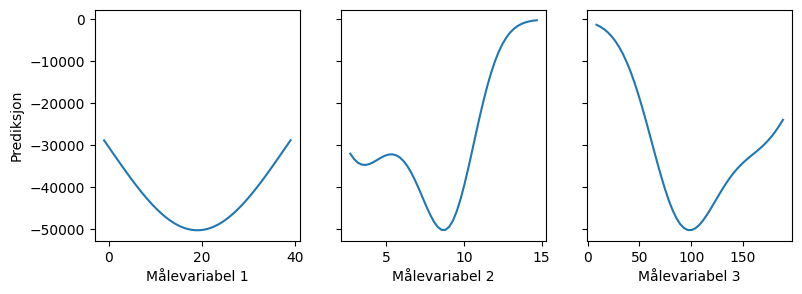

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

# velg hvilket optimum du vil analysere i følgende celler
i = 0

x,y = xdai.process.data_projection(gpr, axes = [0], resolution = 50, center = opt[i])


axs[0].plot(x[0],y)
axs[0].set_xlabel("Målevariabel 1")
x,y = xdai.process.data_projection(gpr, axes = [1], resolution = 50, center = opt[i])


axs[1].plot(x[0], y)
axs[1].set_xlabel("Målevariabel 2")


x,y = xdai.process.data_projection(gpr, axes = [2], resolution = 50, center = opt[i])

axs[2].plot(x[0], y)
axs[2].set_xlabel("Målevariabel 3")
axs[0].set_ylabel("Prediksjon")

plt.show()

In [40]:
print(" Optimized minimum:", opt)

xdai.designer.html_table( np.append(målinger.T, resultater).reshape(-1,15).T, 
                         rows = np.arange(1,len(målinger)+1), 
                         columns = ["Måling nummer", 
                                    "Målevariabel 1", 
                                    "Målevariabel 2",
                                    "Målevariabel 3", 
                                    "Resultater"])

 Optimized minimum: [[10.  3. 90.]]


Måling nummer,Målevariabel 1,Målevariabel 2,Målevariabel 3,Resultater
1,20.0,6.0,135.0,23937.51
2,20.0,6.0,135.0,27070.35
3,20.0,6.0,135.0,25209.71
4,10.0,3.0,135.0,33929.81
5,20.0,3.0,90.0,35876.21
6,20.0,3.0,180.0,29310.04
7,30.0,3.0,135.0,29381.89
8,10.0,6.0,90.0,42652.29
9,10.0,6.0,180.0,27581.62
10,30.0,6.0,90.0,31359.28


In [41]:
print("Bounds for optimization:")
print(bounds)
print(" ")
print("Model length parameters:")
print(optimale_parametre)
print(" ")
print("Model length parameters:")
print(optimale_parametre)


Bounds for optimization:
[[  1   3  10]
 [120 300 480]]
 
Model length parameters:
[0.00475684 0.00276699 0.0002226 ]
 
Model length parameters:
[0.00475684 0.00276699 0.0002226 ]
